In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, r"/home/rupeshknn/projects/qc/pulse-backend-qamp22/qiskit-experiments/")

In [3]:
"""Spectroscopy tests."""
from test.base import QiskitExperimentsTestCase
import numpy as np

from qiskit.qobj.utils import MeasLevel
from qiskit_experiments.framework import ParallelExperiment

from qiskit_experiments.library import QubitSpectroscopy, EFSpectroscopy
from qiskit_experiments.test.mock_iq_backend import MockIQBackend, MockIQParallelBackend
from qiskit_experiments.test.mock_iq_helpers import MockIQSpectroscopyHelper as SpectroscopyHelper
from qiskit_experiments.test.mock_iq_helpers import (
    MockIQParallelExperimentHelper as ParallelExperimentHelper,
)

In [4]:
from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend, ParallelTransmonTestBackend


In [23]:
class TestQubitSpectroscopy(QiskitExperimentsTestCase):
    """Test spectroscopy experiment."""

    def test_spectroscopy_end2end_classified(self):
        """End to end test of the spectroscopy experiment."""

        # exp_helper = SpectroscopyHelper(
        #     line_width=2e6,
        #     iq_cluster_centers=[((-1.0, -1.0), (1.0, 1.0))],
        #     iq_cluster_width=[0.2],
        # )
        # backend = MockIQBackend(
        #     experiment_helper=exp_helper,
        # )
        # backend._configuration.basis_gates = ["x"]
        # backend._configuration.timing_constraints = {"granularity": 16}
        backend = SingleTransmonTestBackend(noise=False)

        qubit = 0
        freq01 = backend.defaults().qubit_freq_est[qubit]
        frequencies = np.linspace(freq01 - 10.0e6, freq01 + 10.0e6, 30)
        self.backend = backend
        spec = QubitSpectroscopy(qubit, frequencies, backend=backend)
        spec.set_experiment_options(amp=0.005)
        spec.set_run_options(meas_level=MeasLevel.CLASSIFIED)
        self.spec = spec
        expdata = spec.run()
        self.assertExperimentDone(expdata)
        result = expdata.analysis_results(1)
        self.assertRoundTripSerializable(result.value, check_func=self.ufloat_equiv)
        self.expdata = expdata
        
        
        self.assertTrue(4.999e9 < result.value.n < 5.001e9)
        self.assertEqual(result.quality, "good")
        self.assertEqual(str(result.device_components[0]), f"Q{qubit}")

#         # Test if we find still find the peak when it is shifted by 5 MHz.
#         exp_helper.freq_offset = 5.0e6
#         spec = QubitSpectroscopy(qubit, frequencies)
#         spec.set_run_options(meas_level=MeasLevel.CLASSIFIED)
#         expdata = spec.run(backend)
#         self.assertExperimentDone(expdata)
#         result = expdata.analysis_results(1)
#         self.assertRoundTripSerializable(result.value, check_func=self.ufloat_equiv)

#         self.assertTrue(5.0049e9 < result.value.n < 5.0051e9)
#         self.assertEqual(result.quality, "good")

    def test_spectroscopy_end2end_kerneled(self):
        """End to end test of the spectroscopy experiment on IQ data."""

        exp_helper = SpectroscopyHelper(
            line_width=2e6,
            iq_cluster_centers=[((-1.0, -1.0), (1.0, 1.0))],
            iq_cluster_width=[0.2],
        )
        backend = MockIQBackend(
            experiment_helper=exp_helper,
        )
        backend._configuration.basis_gates = ["x"]
        backend._configuration.timing_constraints = {"granularity": 16}

        qubit = 0
        freq01 = backend.defaults().qubit_freq_est[qubit]
        frequencies = np.linspace(freq01 - 10.0e6, freq01 + 10.0e6, 21)

        spec = QubitSpectroscopy(qubit, frequencies)
        expdata = spec.run(backend)
        self.assertExperimentDone(expdata)
        result = expdata.analysis_results(1)
        self.assertRoundTripSerializable(result.value, check_func=self.ufloat_equiv)

        self.assertTrue(freq01 - 2e6 < result.value.n < freq01 + 2e6)
        self.assertEqual(result.quality, "good")

        exp_helper.freq_offset = 5.0e6
        exp_helper.iq_cluster_centers = [((1.0, 1.0), (-1.0, -1.0))]

        spec = QubitSpectroscopy(qubit, frequencies)
        expdata = spec.run(backend)
        self.assertExperimentDone(expdata)
        result = expdata.analysis_results(1)
        self.assertRoundTripSerializable(result.value, check_func=self.ufloat_equiv)

        self.assertTrue(freq01 + 3e6 < result.value.n < freq01 + 8e6)
        self.assertEqual(result.quality, "good")

        spec.set_run_options(meas_return="avg")
        expdata = spec.run(backend)
        self.assertExperimentDone(expdata)
        result = expdata.analysis_results(1)
        self.assertRoundTripSerializable(result.value, check_func=self.ufloat_equiv)

        self.assertTrue(freq01 + 3e6 < result.value.n < freq01 + 8e6)
        self.assertEqual(result.quality, "good")

    def test_spectroscopy12_end2end_classified(self):
        """End to end test of the spectroscopy experiment with an x pulse."""

        backend = MockIQBackend(
            experiment_helper=SpectroscopyHelper(
                line_width=2e6,
                iq_cluster_centers=[((-1.0, -1.0), (1.0, 1.0))],
                iq_cluster_width=[0.2],
            ),
        )
        backend._configuration.basis_gates = ["x"]
        backend._configuration.timing_constraints = {"granularity": 16}
        qubit = 0
        freq01 = backend.defaults().qubit_freq_est[qubit]
        frequencies = np.linspace(freq01 - 10.0e6, freq01 + 10.0e6, 21)

        # Note that the backend is not sophisticated enough to simulate an e-f
        # transition so we run the test with g-e.
        spec = EFSpectroscopy(qubit, frequencies)
        spec.backend = backend
        spec.set_run_options(meas_level=MeasLevel.CLASSIFIED)
        expdata = spec.run(backend)
        self.assertExperimentDone(expdata)
        result = expdata.analysis_results(1)
        self.assertRoundTripSerializable(result.value, check_func=self.ufloat_equiv)

        self.assertTrue(freq01 - 2e6 < result.value.n < freq01 + 2e6)
        self.assertEqual(result.quality, "good")

        # Test the circuits
        circ = spec.circuits()[0]
        self.assertEqual(circ.data[0][0].name, "x")
        self.assertEqual(circ.data[1][0].name, "Spec")

    def test_experiment_config(self):
        """Test converting to and from config works"""
        exp = QubitSpectroscopy(1, np.linspace(100, 150, 20) * 1e6)
        loaded_exp = QubitSpectroscopy.from_config(exp.config())
        self.assertNotEqual(exp, loaded_exp)
        self.assertTrue(self.json_equiv(exp, loaded_exp))

    def test_roundtrip_serializable(self):
        """Test round trip JSON serialization"""
        exp = QubitSpectroscopy(1, np.linspace(int(100e6), int(150e6), int(20e6)))
        # Checking serialization of the experiment
        self.assertRoundTripSerializable(exp, self.json_equiv)

    def test_expdata_serialization(self):
        """Test experiment data and analysis data JSON serialization"""
        exp_helper = SpectroscopyHelper(
            line_width=2e6,
            iq_cluster_centers=[((-1.0, -1.0), (1.0, 1.0))],
            iq_cluster_width=[0.2],
        )
        backend = MockIQBackend(
            experiment_helper=exp_helper,
        )
        backend._configuration.basis_gates = ["x"]
        backend._configuration.timing_constraints = {"granularity": 16}

        qubit = 1
        freq01 = backend.defaults().qubit_freq_est[qubit]
        frequencies = np.linspace(freq01 - 10.0e6, freq01 + 10.0e6, 21)
        exp = QubitSpectroscopy(qubit, frequencies)

        exp.set_run_options(meas_level=MeasLevel.CLASSIFIED, shots=1024)
        expdata = exp.run(backend).block_for_results()
        self.assertExperimentDone(expdata)

        # Checking serialization of the experiment data
        self.assertRoundTripSerializable(expdata, self.experiment_data_equiv)

        # Checking serialization of the analysis
        self.assertRoundTripSerializable(expdata.analysis_results(1), self.analysis_result_equiv)

    def test_kerneled_expdata_serialization(self):
        """Test experiment data and analysis data JSON serialization"""
        exp_helper = SpectroscopyHelper(
            line_width=2e6,
            iq_cluster_centers=[((-1.0, -1.0), (1.0, 1.0))],
            iq_cluster_width=[0.2],
        )
        backend = MockIQBackend(
            experiment_helper=exp_helper,
        )
        backend._configuration.basis_gates = ["x"]
        backend._configuration.timing_constraints = {"granularity": 16}

        qubit = 1
        freq01 = backend.defaults().qubit_freq_est[qubit]
        frequencies = np.linspace(freq01 - 10.0e6, freq01 + 10.0e6, 21)
        exp = QubitSpectroscopy(qubit, frequencies)

        exp.set_run_options(meas_level=MeasLevel.KERNELED, shots=1024)
        expdata = exp.run(backend).block_for_results()
        self.assertExperimentDone(expdata)

        # Checking serialization of the experiment data
        self.assertRoundTripSerializable(expdata, self.experiment_data_equiv)

        # Checking serialization of the analysis
        self.assertRoundTripSerializable(expdata.analysis_results(1), self.analysis_result_equiv)

    def test_parallel_experiment(self):
        """Test for parallel experiment"""
        # backend initialization
        iq_cluster_centers = [
            ((-1.0, 0.0), (1.0, 0.0)),
            ((0.0, -1.0), (0.0, 1.0)),
            ((3.0, 0.0), (5.0, 0.0)),
        ]

        parallel_backend = MockIQParallelBackend(
            experiment_helper=None,
            rng_seed=0,
        )
        parallel_backend._configuration.basis_gates = ["x"]
        parallel_backend._configuration.timing_constraints = {"granularity": 16}

        # experiment hyper parameters
        qubit1 = 0
        qubit2 = 1
        freq01 = parallel_backend.defaults().qubit_freq_est[qubit1]
        freq02 = parallel_backend.defaults().qubit_freq_est[qubit2]

        # experiments initialization
        frequencies1 = np.linspace(freq01 - 10.0e6, freq01 + 10.0e6, 23)
        frequencies2 = np.linspace(freq02 - 10.0e6, freq02 + 10.0e6, 21)

        exp_list = [
            QubitSpectroscopy(
                qubit1,
                frequencies1,
            ),
            QubitSpectroscopy(
                qubit2,
                frequencies2,
            ),
        ]

        exp_helper_list = [
            SpectroscopyHelper(iq_cluster_centers=iq_cluster_centers),
            SpectroscopyHelper(iq_cluster_centers=iq_cluster_centers),
        ]
        parallel_helper = ParallelExperimentHelper(exp_list, exp_helper_list)

        parallel_backend.experiment_helper = parallel_helper

        # initializing parallel experiment
        par_experiment = ParallelExperiment(exp_list, backend=parallel_backend)
        par_experiment.set_run_options(meas_level=MeasLevel.KERNELED, meas_return="single")

        par_data = par_experiment.run().block_for_results()
        self.assertExperimentDone(par_data)

        # since under _experiment in kwargs there is an argument of the backend which isn't serializable.
        par_data._experiment = None
        # Checking serialization of the experiment data
        self.assertRoundTripSerializable(par_data, self.experiment_data_equiv)

        for child_data in par_data.child_data():
            self.assertRoundTripSerializable(child_data, self.experiment_data_equiv)

In [24]:
obj = TestQubitSpectroscopy("test_spectroscopy_end2end_classified")
obj.setUp()
obj.test_spectroscopy_end2end_classified()

# suite = unittest.makeSuite(TestEFRabi, 'test')
# TestEFRabi_result = unittest.TestResult()
# suite.run(TestEFRabi_result)

AssertionError: 'bad' != 'good'
- bad
+ good


In [25]:
obj.expdata.analysis_results(1).value.n

5000001329.682457

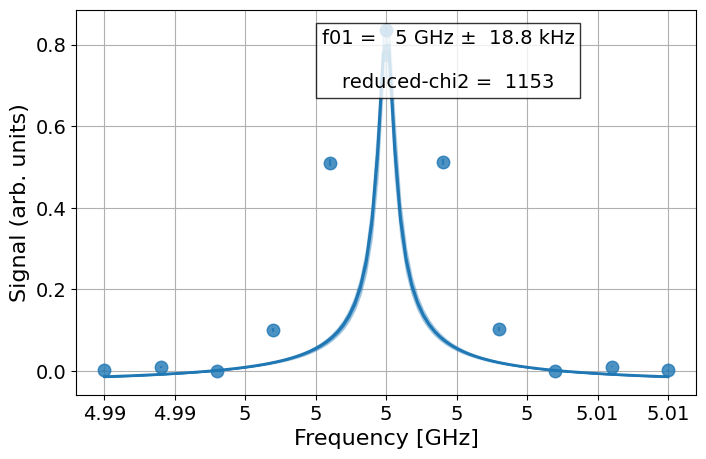

In [26]:
obj.expdata.figure(0)

In [22]:
# obj.spec.backend.discriminator[0]